In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats



import SessionTools.two_photon as st2p

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [2]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R60D05LexA_jGCaMP7b_CsChrimsontdT_R18B05Gal4_TBHRNAi')
sess_df = pd.read_csv(basedir / 'sessions.csv')
sess_df = sess_df.iloc[:-1]
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] + '_' + row['rnai_cond'] for _, row in sess_df.iterrows()]
sess_df['fly_id'] = [row['date']+'_'+row['fly']  for _, row in sess_df.iterrows()]
sess_df['mean offset'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['offset var.'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['mean vec. len'] = [np.nan for _, row in sess_df.iterrows()]


# figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/LabMeetings/05_09_2024/EL_jGCaMP7f_CsChrimsontdT')
# figfolder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]

Index(['date', 'fly', 'sess', 'rnai_cond', 'fictrac file',
       'fictrac scan number', 'remap', 'offset', 'usable', 'notes'],
      dtype='object')


In [3]:
sess_df.head()

,date,fly,sess,rnai_cond,fictrac file,fictrac scan number,remap,offset,usable,notes,fly_id,mean offset,offset var.,mean vec. len
5,15_10_2024,fly2,baseline-000,uas_control,fictrac-20241015_174309.dat,0,0,-1,1,"remapping didn’t work,",15_10_2024_fly2,NaN,NaN,NaN
6,15_10_2024,fly2,remap_0deg-003,uas_control,fictrac-20241015_174309.dat,3,1,0,1,last round of pairing looks wonky,15_10_2024_fly2,NaN,NaN,NaN
7,15_10_2024,fly2,post_0deg-004,uas_control,fictrac-20241015_174309.dat,4,0,0,1,NaN,15_10_2024_fly2,NaN,NaN,NaN
8,15_10_2024,fly2,remap_180deg-005,uas_control,fictrac-20241015_174309.dat,5,1,180,1,NaN,15_10_2024_fly2,NaN,NaN,NaN
9,15_10_2024,fly2,post_180deg-007,uas_control,fictrac-20241015_174309.dat,7,0,180,1,NaN,15_10_2024_fly2,NaN,NaN,NaN


In [4]:
for index,row in sess_df.iterrows():
   
    outdir = pathlib.PurePath( basedir  / row['rnai_cond'] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    dff = pp.calculate_zscored_F('rois', exp_detrend=True, zscore=False, background_ts='background')[-1,:,:] -1

    heading = np.angle(np.exp(1j*(-1*pp.voltage_recording_aligned[' Heading'].to_numpy()-np.pi)))
    h_mask = np.abs(heading)<2.5


    x_f,y_f = st2p.utilities.pol2cart(dff ,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
    rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))

    _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
    # print(offset.shape)


    x_o, y_o = st2p.utilities.pol2cart(np.ones(heading[h_mask].shape), offset[h_mask])
    r, offset_mu = st2p.utilities.cart2pol(x_o.mean(), y_o.mean())

    sess_df.loc[index, 'mean offset'] = offset_mu
    sess_df.loc[index, 'mean vec. len'] = r
    sess_df.loc[index, 'offset var.'] = sp.stats.circvar(offset[h_mask])


In [5]:
uas_ctrl_sess_df = sess_df[sess_df['rnai_cond']=='uas_control']
flies = uas_ctrl_sess_df['fly_id'].unique()
print(flies.shape)

uas_ctrl_data = {'fly': [],
              'baseline_mu':[],
              'baseline_var':[],
              'baseline_r':[],
              '0deg_mu':[],
              '0deg_var':[],
              '0deg_r': [],
              '180deg_mu':[],
              '180deg_var':[],
              '180deg_r':[],
             }

for fly in flies:
    _df = uas_ctrl_sess_df['fly_id']==fly
    uas_ctrl_data['fly'].append(fly)
    
    baseline = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['remap']==0) & (sess_df['offset']==-1)]
    uas_ctrl_data['baseline_mu'].append(baseline['mean offset'].mean())
    uas_ctrl_data['baseline_var'].append(baseline['offset var.'].mean())
    uas_ctrl_data['baseline_r'].append(baseline['mean vec. len'].mean())
    
    deg0 = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['remap']==0) & (sess_df['offset']==0)]
    uas_ctrl_data['0deg_mu'].append(deg0['mean offset'].mean())
    uas_ctrl_data['0deg_var'].append(deg0['offset var.'].mean())
    uas_ctrl_data['0deg_r'].append(deg0['mean vec. len'].mean())
    
    deg180 = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['remap']==0) & (sess_df['offset']==180)]
    uas_ctrl_data['180deg_mu'].append(deg180['mean offset'].mean())
    uas_ctrl_data['180deg_var'].append(deg180['offset var.'].mean())
    uas_ctrl_data['180deg_r'].append(deg180['mean vec. len'].mean())
    
uas_ctrl_data = pd.DataFrame(uas_ctrl_data)
uas_ctrl_data.head()

(6,)


,fly,baseline_mu,baseline_var,baseline_r,0deg_mu,0deg_var,0deg_r,180deg_mu,180deg_var,180deg_r
0,15_10_2024_fly2,2.713481,0.681527,0.318473,-2.094456,0.756076,0.243924,2.976196,0.623162,0.376838
1,16_10_2024_fly1,2.854182,0.823223,0.176777,-0.023873,0.794530,0.205470,3.113809,0.692447,0.307553
2,16_10_2024_fly2,2.793139,0.815556,0.184444,-0.461664,0.676967,0.323033,-1.858408,0.829061,0.170939
3,16_10_2024_fly3,2.634340,0.537131,0.462869,0.056657,0.635897,0.364103,2.755763,0.515648,0.484352
4,14_10_2024_fly1,-1.026113,0.733281,0.266719,-1.380807,0.790022,0.209978,-2.241628,0.785184,0.214816


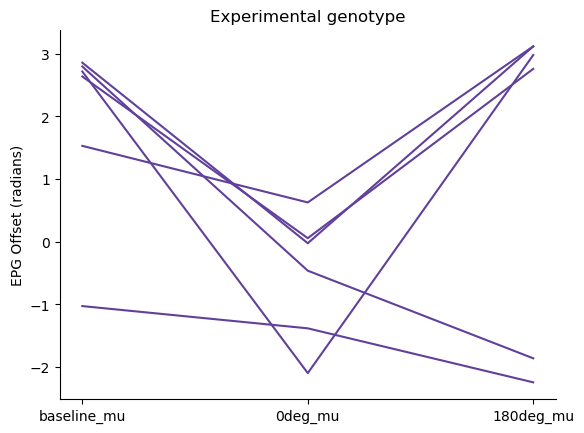

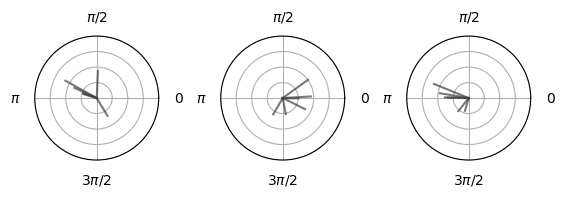

In [6]:
fig, ax= plt.subplots()

_ = ax.plot(uas_ctrl_data[['baseline_mu','0deg_mu','180deg_mu']].T, color=plt.cm.Purples(.8))
ax.set_ylabel('EPG Offset (radians)')
ax.set_title('Experimental genotype')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.savefig(figfolder / "EL_remap.pdf")

fig, ax = plt.subplots(1,3,subplot_kw={'projection': 'polar'})
fig.subplots_adjust(wspace=.5)
for index,row in uas_ctrl_data.iterrows():
    ax[0].plot(row['baseline_mu']*np.ones([2,]), [0, row['baseline_r']], color=plt.cm.Greys(.8), alpha=.7)
    ax[1].plot(row['0deg_mu']*np.ones([2,]), [0, row['0deg_r']], color=plt.cm.Greys(.8), alpha=.7)
    ax[2].plot(row['180deg_mu']*np.ones([2,]), [0, row['180deg_r']], color=plt.cm.Greys(.8), alpha=.7)


    
for a in ax:
    a.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    a.set_yticks([0,.2,.4,.6,.8],['','','','',''])

In [7]:
rnai_sess_df = sess_df[sess_df['rnai_cond']=='rnai']
flies = rnai_sess_df['fly_id'].unique()
print(flies.shape)

rnai_data = {'fly': [],
              'baseline_mu':[],
              'baseline_var':[],
              'baseline_r':[],
              '0deg_mu':[],
              '0deg_var':[],
              '0deg_r': [],
              '180deg_mu':[],
              '180deg_var':[],
              '180deg_r':[],
             }

for fly in flies:
    _df = rnai_sess_df['fly_id']==fly
    rnai_data['fly'].append(fly)
    
    baseline = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['remap']==0) & (sess_df['offset']==-1)]
    rnai_data['baseline_mu'].append(baseline['mean offset'].mean())
    rnai_data['baseline_var'].append(baseline['offset var.'].mean())
    rnai_data['baseline_r'].append(baseline['mean vec. len'].mean())
    
    deg0 = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['remap']==0) & (sess_df['offset']==0)]
    rnai_data['0deg_mu'].append(deg0['mean offset'].mean())
    rnai_data['0deg_var'].append(deg0['offset var.'].mean())
    rnai_data['0deg_r'].append(deg0['mean vec. len'].mean())
    
    deg180 = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['remap']==0) & (sess_df['offset']==180)]
    rnai_data['180deg_mu'].append(deg180['mean offset'].mean())
    rnai_data['180deg_var'].append(deg180['offset var.'].mean())
    rnai_data['180deg_r'].append(deg180['mean vec. len'].mean())
    
rnai_data = pd.DataFrame(rnai_data)
rnai_data

(7,)


,fly,baseline_mu,baseline_var,baseline_r,0deg_mu,0deg_var,0deg_r,180deg_mu,180deg_var,180deg_r
0,13_09_2024_fly1,0.099283,0.832957,0.167043,0.628843,0.793009,0.206991,0.079809,0.748333,0.251667
1,13_09_2024_fly2,-1.381253,0.908275,0.091725,0.123039,0.937724,0.062276,-2.473553,0.872935,0.127065
2,16_09_2024_fly1,-2.748137,0.923724,0.076276,-2.977389,0.969988,0.030012,3.029587,0.972254,0.027746
3,16_09_2024_fly2,1.444687,0.913809,0.086191,-0.810891,0.880102,0.119898,-0.263564,0.938203,0.061797
4,17_09_2024_fly1,2.228529,0.884215,0.115785,2.514798,0.858744,0.141256,2.826436,0.895983,0.104017
5,17_10_2024_fly2,0.815555,0.951368,0.048632,-2.410881,0.975805,0.024195,0.391207,0.936238,0.063762
6,19_10_2024_fly1,2.480143,0.945157,0.054843,2.380941,0.899160,0.100840,NaN,NaN,NaN


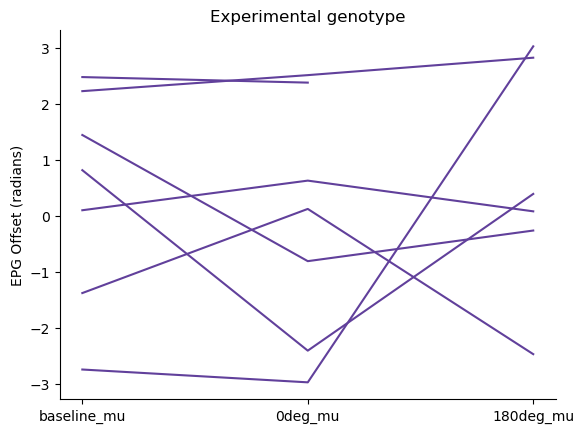

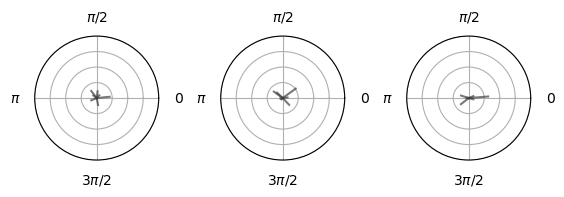

In [8]:
fig, ax= plt.subplots()

_ = ax.plot(rnai_data[['baseline_mu','0deg_mu','180deg_mu']].T, color=plt.cm.Purples(.8))
ax.set_ylabel('EPG Offset (radians)')
ax.set_title('Experimental genotype')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.savefig(figfolder / "EL_remap.pdf")

fig, ax = plt.subplots(1,3,subplot_kw={'projection': 'polar'})
fig.subplots_adjust(wspace=.5)
for index,row in rnai_data.iterrows():
    ax[0].plot(row['baseline_mu']*np.ones([2,]), [0, row['baseline_r']], color=plt.cm.Greys(.8), alpha=.7)
    ax[1].plot(row['0deg_mu']*np.ones([2,]), [0, row['0deg_r']], color=plt.cm.Greys(.8), alpha=.7)
    ax[2].plot(row['180deg_mu']*np.ones([2,]), [0, row['180deg_r']], color=plt.cm.Greys(.8), alpha=.7)


    
for a in ax:
    a.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    a.set_yticks([0,.2,.4,.6,.8],['','','','',''])